# Problem Statement

The goal of this notebook is to create a deep learning model that can detect which Tweets are about actual disasters and which are not utilising its various techniques.

---

## NLP

The study of how computers interact with human (natural) languages is known as natural language processing (NLP), and it is a subfield of linguistics, computer science, information engineering, and artificial intelligence. Its focus is on how to program computers to process and analyse large amounts of natural language data.

![Benjamin Bannekat](https://static.javatpoint.com/tutorial/nlp/images/what-is-nlp.png)

# Importing Libraries

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GRU
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\win10\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\win10\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading the dataset

**Datatset Description**

- Size of the train data : 38065
- Size of the test data : 13052
- Number of rows in train data : 7613
- Number of rows in test data : 3263
- Column names : id, keyword, location, text and target

  1. id - a unique identifier for each tweet
  2. text - the text of the tweet
  3. location - the location the tweet was sent from (may be blank)
  4. keyword - a particular keyword from the tweet (may be blank)
  5. target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)
  
  
- Datatyes :
  1. id : int
  2. keyword : object
  3. location : object
  4. text : object 
  5. target : int
  


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Exploratory data analysis

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print('Shape of the train data ',train.shape)
print('Shape of the test data ',test.shape)

Shape of the train data  (7613, 5)
Shape of the test data  (3263, 4)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
print('Size of the train data ',train.size)
print('Size of the test data ',test.size)

Size of the train data  38065
Size of the test data  13052


In [9]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

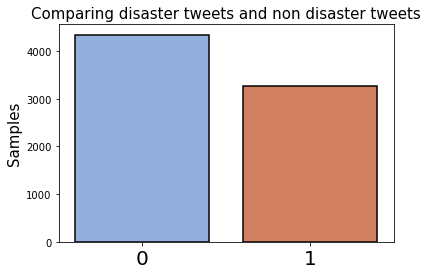

In [10]:
target=train['target'].value_counts()
sns.barplot(target.index,target,edgecolor=(0,0,0),linewidth=1.5, palette = ['#87ace8','#e3784d'])
plt.title('Comparing disaster tweets and non disaster tweets',fontsize=15)
plt.xticks(fontsize=20)
plt.ylabel('Samples',fontsize=15)
plt.show()

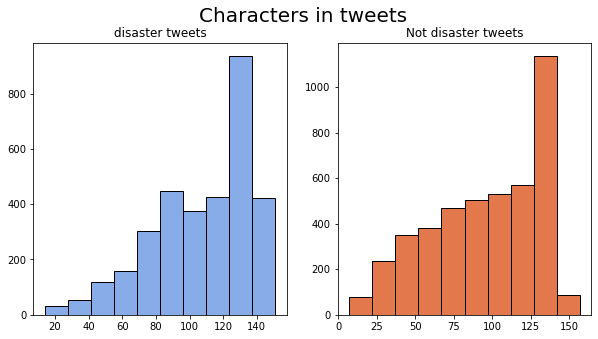

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='#87ace8', edgecolor ='k')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='#e3784d', edgecolor ='k')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets',fontsize=20)

plt.show()

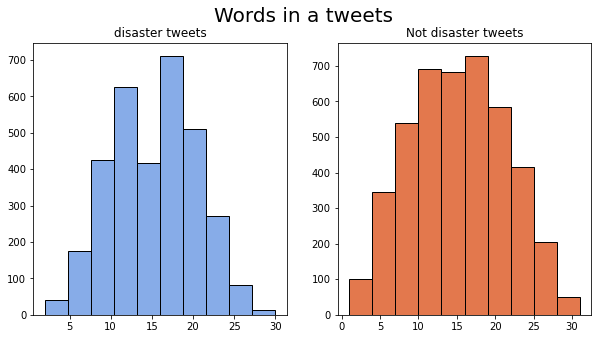

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#87ace8', edgecolor ='k')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#e3784d', edgecolor ='k')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweets',fontsize=20)
plt.show()

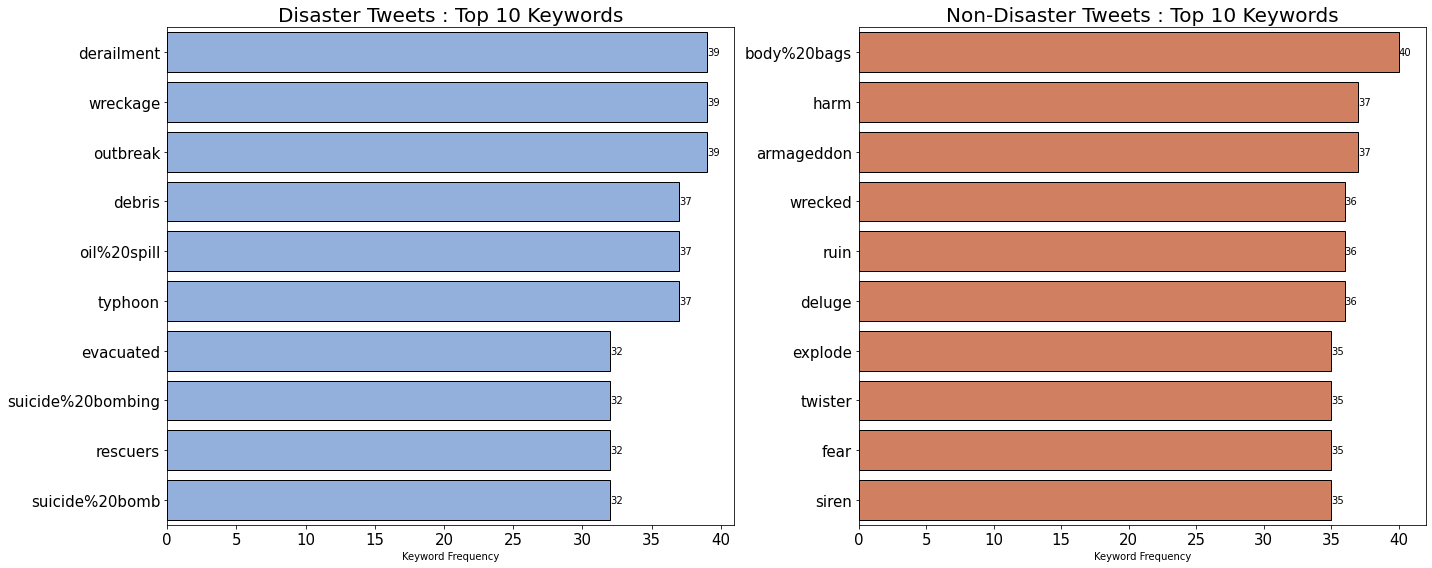

In [13]:
disaster_keywords = train.loc[train["target"] == 1]["keyword"].value_counts()
non_disaster_keywords = train.loc[train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
ax1 = sns.barplot(y=disaster_keywords[0:10].index, x=disaster_keywords[0:10], orient='h', ax=ax[0], color='#87ace8', edgecolor ='k')
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title("Disaster Tweets : Top 10 Keywords",fontsize=20)
ax[0].set_xlabel("Keyword Frequency")
for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
    
    
ax2 = sns.barplot(y=non_disaster_keywords[0:10].index, x= non_disaster_keywords[0:10], orient='h', ax=ax[1], color='#e3784d', edgecolor ='k')
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title("Non-Disaster Tweets : Top 10 Keywords",fontsize=20)
ax[1].set_xlabel("Keyword Frequency")
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
plt.tight_layout()
plt.show()

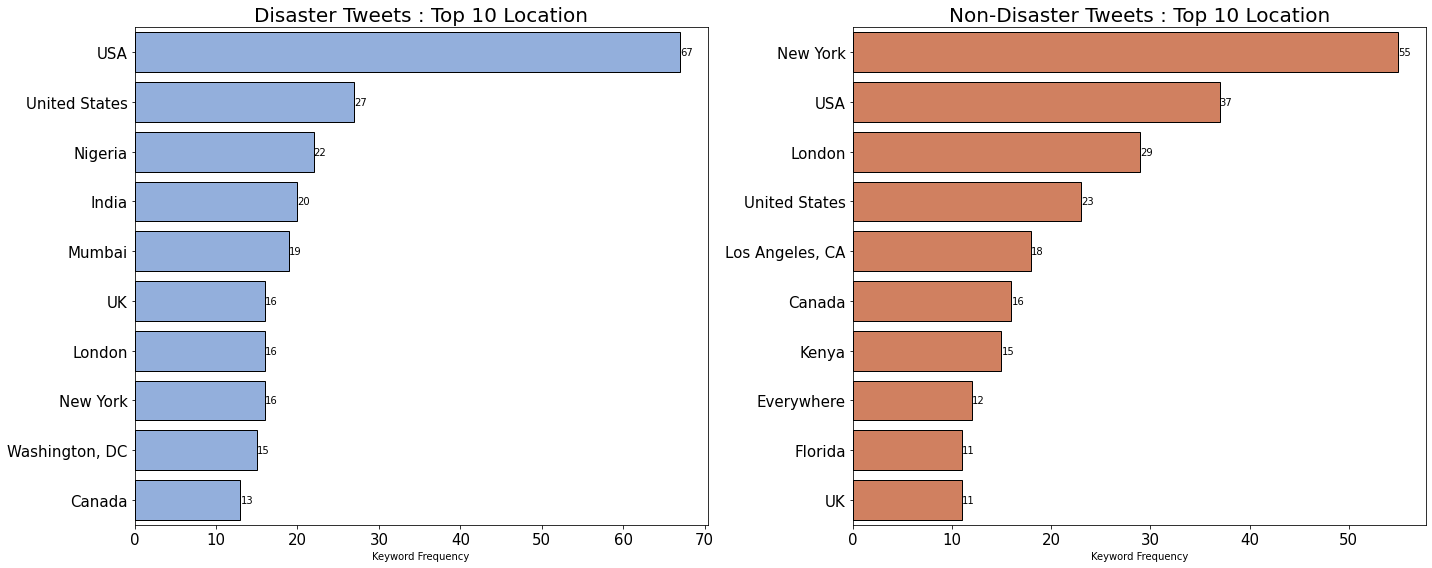

In [14]:
disaster_keywords = train.loc[train["target"] == 1]["location"].value_counts()
non_disaster_keywords = train.loc[train["target"] == 0]["location"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
ax1 = sns.barplot(y=disaster_keywords[0:10].index, x=disaster_keywords[0:10], ax=ax[0], color='#87ace8', edgecolor ='k')
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title("Disaster Tweets : Top 10 Location",fontsize=20)
ax[0].set_xlabel("Keyword Frequency")
for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
    
    
ax2 = sns.barplot(y=non_disaster_keywords[0:10].index, x= non_disaster_keywords[0:10],ax=ax[1], color='#e3784d', edgecolor ='k')
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title("Non-Disaster Tweets : Top 10 Location",fontsize=20)
ax[1].set_xlabel("Keyword Frequency")
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
plt.tight_layout()
plt.show()

# Data Cleaning

**The text column in our dataset contains hyperlinks, punctuation, stop words, numbers. So we have to remove all these using text processing. After this as the data is in the text form, we need to preprocess the texual data and performed the following steps:**

1- Removing URLS

2- Removing Punctuation

3- Tokenization (Tokenization is the first step in NLP. It is the process of breaking strings into tokens which in turn are small structures or units. Tokenization involves three steps which are breaking a complex sentence into words, understanding the importance of each word with respect to the sentence and finally produce structural description on an input sentence.)

4- Removing stopwords (Stop words are the most common words in a language like “the”, “a”, “at”, “for”, “above”, “on”, “is”, “all”. These words do not provide any meaning and are usually removed from texts. We can remove these stop words using nltk library)

5- Lemmatizing (In simpler terms, it is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.)

6- Combiningthe tokenized text into final sentence.

In [15]:
# Defining different functions to clean and preprocess the text data 

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_punctuation(text):
    PUNCT_TO_REMOVE = string.punctuation
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_stopwords(words):
    stop_words=set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]


def lemmatizing(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def final_text(words):
    return ' '.join(words)

def preprocess_data(dataframe):
    dataframe["text"] = dataframe["text"].str.lower()

    dataframe["text"] = dataframe["text"].apply(lambda text: remove_urls(text))

    dataframe["text"] = dataframe["text"].apply(lambda text: remove_punctuation(text))

    dataframe['text']=dataframe['text'].apply(str)

    dataframe['text']=dataframe['text'].apply(lambda x:word_tokenize(x))
    dataframe['text']=dataframe['text'].apply(lambda x: remove_stopwords(x))

    dataframe['text']=dataframe['text'].apply(lambda x: lemmatizing(x))
    
    dataframe['text']=dataframe['text'].apply(lambda x:final_text(x))
    
    return dataframe

In [16]:
# preprocess and clean the train data 
preprocess_data(train)

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane holding bridge collapse nearby...,1
7609,10870,NaN,NaN,ariaahrary thetawniest control wild fire calif...,1
7610,10871,NaN,NaN,m194 0104 utc5km volcano hawaii,1
7611,10872,NaN,NaN,police investigating ebike collided car little...,1


# Feature Extraction

The words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).

The scikit-learn library offers easy-to-use tools to perform both tokenization and feature extraction of your text data. We have used TF-IDF vectorizer, Term frequency-inverse document frequency is a text vectorizer that transforms the text into a usable vector. It combines 2 concepts, Term Frequency (TF) and Document Frequency (DF). The term frequency is the number of occurrences of a specific term in a document.

In [17]:
# Initializing the TF-IDF vectorizer

vect=TfidfVectorizer(min_df=2
                      ,max_features = None,analyzer="word",  ngram_range=(1,2) 
                           ).fit(train['text'])
x_train_vect=vect.transform(train['text'])

y = train[['target']]

# Splitting the dataset into train, test data
max_features=4000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train['text'].values)
X = tokenizer.texts_to_sequences(train['text'].values)
X = pad_sequences(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =42)



# Model Building

**Model Architecture**

We have used sequential model and added the LSTM layer in it with 32 neurons and activation function as relu and a dropout of 0.2. The input length is the length of all the features in the X_train. The output layer contains one neuron only with sigmoid as activation function as the output is in binary form. Optimizer used for the model is adam and loss is binary_crossentropy.

In [18]:

embed_dim = 32
lstm_out = 32

# Initializing model
model_1 = Sequential()
model_1.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model_1.add(Dropout(0.2))

# input layer and LSTM layer with 32 neurons
model_1.add(LSTM(lstm_out, dropout=0.2,activation = 'relu'))

# output layer with sigmoid activation
model_1.add(Dense(1,activation='sigmoid'))

model_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 32)            128000    
                                                                 
 dropout (Dropout)           (None, 21, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 136,353
Trainable params: 136,353
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# training the model on training dataset
history1 = model_1.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
191/191 [==============================] - 2s 7ms/step - loss: 0.6042 - accuracy: 0.6573 - val_loss: 0.4727 - val_accuracy: 0.7958
Epoch 2/10
191/191 [==============================] - 1s 6ms/step - loss: 0.3986 - accuracy: 0.8286 - val_loss: 0.4388 - val_accuracy: 0.8037
Epoch 3/10
191/191 [==============================] - 1s 6ms/step - loss: 0.3345 - accuracy: 0.8608 - val_loss: 0.4783 - val_accuracy: 0.7846
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2880 - accuracy: 0.8833 - val_loss: 0.5056 - val_accuracy: 0.7899
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2544 - accuracy: 0.8992 - val_loss: 0.5350 - val_accuracy: 0.7794
Epoch 6/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2257 - accuracy: 0.9095 - val_loss: 0.7032 - val_accuracy: 0.7781
Epoch 7/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1979 - accuracy: 0.9187 - val_loss: 0.6638 - val_accuracy: 0.7656
Epoch 

In [20]:
# Model evaluation
predictions = model_1.predict(X_test)
prediction = []
for i in predictions:
    if i[0]>0.5:
        prediction.append(1)
    else:
        prediction.append(0)
    
acc_1 = round(accuracy_score(y_test, prediction)*100, 2)
print('Accuracy : ', acc_1)
print('-'*50)
print('Classification report : ')
print(classification_report(y_test, prediction))
print('-'*50)
print('Confusion matrix')
print(confusion_matrix(y_test, prediction))

48/48 [==============================] - 0s 2ms/step
Accuracy :  73.74
--------------------------------------------------
Classification report : 
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       874
           1       0.69      0.71      0.70       649

    accuracy                           0.74      1523
   macro avg       0.73      0.73      0.73      1523
weighted avg       0.74      0.74      0.74      1523

--------------------------------------------------
Confusion matrix
[[663 211]
 [189 460]]


# Hyperparameter Tuning

In [21]:

embed_dim = 64
lstm_out = 64

# Initializing model
model_2 = Sequential()
model_2.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model_2.add(Dropout(0.2))

# input layer and LSTM layer with 64 neurons
model_2.add(LSTM(lstm_out, dropout=0.2,activation = 'tanh'))

model_2.add(Dense(32, activation = 'tanh'))
# output layer with sigmoid activation
model_2.add(Dense(1,activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21, 64)            256000    
                                                                 
 dropout_1 (Dropout)         (None, 21, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 291,137
Trainable params: 291,137
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
# training the model on training dataset
history2 = model_2.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
191/191 [==============================] - 3s 10ms/step - loss: 0.5449 - accuracy: 0.7258 - val_loss: 0.4546 - val_accuracy: 0.7912
Epoch 2/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3930 - accuracy: 0.8294 - val_loss: 0.4542 - val_accuracy: 0.7905
Epoch 3/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3593 - accuracy: 0.8452 - val_loss: 0.4662 - val_accuracy: 0.7912
Epoch 4/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3388 - accuracy: 0.8608 - val_loss: 0.4709 - val_accuracy: 0.7905
Epoch 5/10
191/191 [==============================] - 1s 8ms/step - loss: 0.3289 - accuracy: 0.8632 - val_loss: 0.4753 - val_accuracy: 0.8024
Epoch 6/10
191/191 [==============================] - 1s 8ms/step - loss: 0.3183 - accuracy: 0.8711 - val_loss: 0.4779 - val_accuracy: 0.7873
Epoch 7/10
191/191 [==============================] - 1s 8ms/step - loss: 0.3094 - accuracy: 0.8714 - val_loss: 0.4901 - val_accuracy: 0.7886
Epoch

In [23]:
# Model evaluation
predictions = model_2.predict(X_test)
prediction = []
for i in predictions:
    if i[0]>0.5:
        prediction.append(1)
    else:
        prediction.append(0)
    
acc_2 = round(accuracy_score(y_test, prediction)*100, 2)
print('Accuracy : ', acc_2)
print('-'*50)
print('Classification report : ')
print(classification_report(y_test, prediction))
print('-'*50)
print('Confusion matrix')
print(confusion_matrix(y_test, prediction))

48/48 [==============================] - 1s 3ms/step
Accuracy :  78.0
--------------------------------------------------
Classification report : 
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       874
           1       0.73      0.78      0.75       649

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523

--------------------------------------------------
Confusion matrix
[[684 190]
 [145 504]]


In [24]:

embed_dim = 128
lstm_out = 128

# Initializing model
model_3 = Sequential()
model_3.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model_3.add(Dropout(0.2))

# input layer and LSTM layer with 64 neurons
model_3.add(LSTM(lstm_out, dropout=0.2,activation = 'tanh'))
model_3.add(Dense(100,activation = 'tanh'))
# output layer with sigmoid activation
model_3.add(Dense(1,activation='sigmoid'))

model_3.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 21, 128)           512000    
                                                                 
 dropout_2 (Dropout)         (None, 21, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 100)               12900     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 656,585
Trainable params: 656,585
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# training the model on training dataset
history3 = model_3.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
191/191 [==============================] - 6s 21ms/step - loss: 0.5268 - accuracy: 0.7460 - val_loss: 0.4654 - val_accuracy: 0.7761
Epoch 2/10
191/191 [==============================] - 4s 20ms/step - loss: 0.3873 - accuracy: 0.8317 - val_loss: 0.4498 - val_accuracy: 0.7932
Epoch 3/10
191/191 [==============================] - 4s 22ms/step - loss: 0.3534 - accuracy: 0.8514 - val_loss: 0.4549 - val_accuracy: 0.8011
Epoch 4/10
191/191 [==============================] - 3s 18ms/step - loss: 0.3289 - accuracy: 0.8677 - val_loss: 0.4773 - val_accuracy: 0.7905
Epoch 5/10
191/191 [==============================] - 3s 16ms/step - loss: 0.3074 - accuracy: 0.8788 - val_loss: 0.4946 - val_accuracy: 0.7827
Epoch 6/10
191/191 [==============================] - 4s 20ms/step - loss: 0.2863 - accuracy: 0.8893 - val_loss: 0.5244 - val_accuracy: 0.7853
Epoch 7/10
191/191 [==============================] - 4s 18ms/step - loss: 0.2674 - accuracy: 0.8952 - val_loss: 0.5202 - val_accuracy: 0.7649

In [26]:
# Model evaluation
predictions = model_3.predict(X_test)
prediction = []
for i in predictions:
    if i[0]>0.5:
        prediction.append(1)
    else:
        prediction.append(0)
    
acc_3 = round(accuracy_score(y_test, prediction)*100, 2)
print('Accuracy : ', acc_3)
print('-'*50)
print('Classification report : ')
print(classification_report(y_test, prediction))
print('-'*50)
print('Confusion matrix')
print(confusion_matrix(y_test, prediction))

48/48 [==============================] - 0s 4ms/step
Accuracy :  75.05
--------------------------------------------------
Classification report : 
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       874
           1       0.70      0.73      0.71       649

    accuracy                           0.75      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.75      0.75      0.75      1523

--------------------------------------------------
Confusion matrix
[[671 203]
 [177 472]]


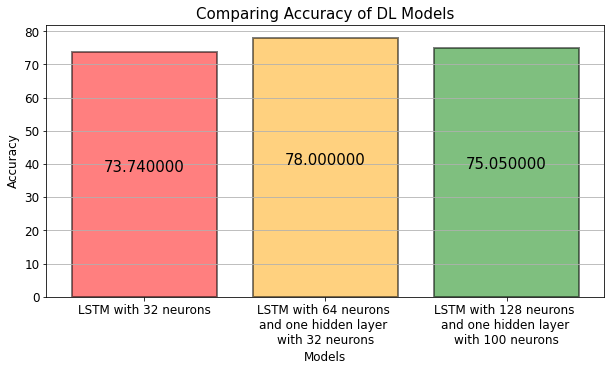

In [28]:
accuracy_scores = [acc_1, acc_2, acc_3]
model_names = ['LSTM with 32 neurons', 'LSTM with 64 neurons \nand one hidden layer \nwith 32 neurons', 'LSTM with 128 neurons \nand one hidden layer \nwith 100 neurons']

plt.figure(figsize=(10,5))
plt.grid(b=True, which='major', axis='y')
plt.title('Comparing Accuracy of DL Models',fontsize=15)
colors=['red','orange','green']
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('Models',fontsize=12)
bar = plt.bar(model_names,accuracy_scores,edgecolor='black',color=colors, linewidth=2, alpha =0.5)
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2, 0.5*(h), '%f'%(h),
                    ha='center', va='bottom',fontsize=15)
autolabel(bar)

For hypertuning parameters, we have focussed on the layers, neurons and the activation function. 

For second model, we have defined an architecture of one input layer of LSTM with 64 neurons and activation function as tanh, one hidden layer with 32 neurons and an output layer same as the model one.

For third model, the architecture is same as second model but we have changed some parameters like, input layer with 128 neurons and hidden layer with 100 neurons. 



In [30]:
preprocess_data(test)

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill 28 china taiwan
...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,storm ri worse last hurricane cityamp3others h...
3260,10868,NaN,NaN,green line derailment chicago
3261,10874,NaN,NaN,meg issue hazardous weather outlook hwo


In [38]:
max_features=4000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(test['text'].values)
X = tokenizer.texts_to_sequences(test['text'].values)
X = pad_sequences(X)

predictions_test = model_2.predict(X)
prediction = []
for i in predictions_test:
    if i[0]>0.5:
        prediction.append(1)
    else:
        prediction.append(0)
        
submission_1 = pd.DataFrame(data = test['id'])
submission_1['target'] = prediction
submission_1.to_csv('Submission_1.csv',index = False)

102/102 [==============================] - 0s 2ms/step


# Conclusion


From the above chart we can conclude that the second model achieved by changing some parameters is giving the highest accuracy from all of the different models. The model with tanh function is fitted well on the train dataset than the relu function. Increasing layers and neurons and changing activation function helps in gaining a better accuracy. In future, we can try with other models like GRU or RNN etc and tune their parameters to get more better accuracy.